# Evolutionary Algorithms

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Selection

### Tournament Operator

In [2]:
def tournament(list_pop: list, fitness_funct, tournament_size, n_tournaments, minimize=False):
    selected = []
    for _ in range(n_tournaments):
        rand_inds = random.sample(list_pop, tournament_size)
        best_ind = rand_inds[0]
        fitness_val = fitness_funct(best_ind)
        for ind in rand_inds[1:]:
            new_fitness = fitness_funct(ind)
            if minimize:
                if new_fitness <= fitness_val:
                    best_ind = ind
                    fitness_val = new_fitness
            else:
                if new_fitness >= fitness_val:
                    best_ind = ind
                    fitness_val = new_fitness
        selected.append(best_ind)
    return selected

### Stochastic Universal Selection

In [3]:
def SUS(list_pop: list, fitness_funct, k, minimize=False):
    fitness_list = [fitness_funct(ind) for ind in list_pop]

     # Si estamos minimizando, invertimos los valores
    if minimize:
        max_fitness = max(fitness_list)
        fitness_list = [max_fitness - fit for fit in fitness_list]
    
    # Evita división entre cero
    total_fitness = np.sum(fitness_list)
    if total_fitness == 0:
        probs_list = np.array([1/len(fitness_list) for _ in fitness_list])
    else:
        probs_list = np.array(fitness_list)/total_fitness
    
    # Probabilidades acumuladas
    cum_probs = np.cumsum(probs_list)
    
    # Iniciar desde un punto aleatorio en [0, 1/k)
    start = random.uniform(0, 1 / k)
    pointers = [start + i / k for i in range(k)]
    
    sols = []
    idx = 0
    for p in pointers:
        while p > cum_probs[idx]:
            idx += 1
        sols.append(list_pop[idx])
    
    return sols

### Proportional sampling

In [4]:
def RWS(list_pop: list, fitness_funct, k, minimize=False):
    fitness_list = [fitness_funct(ind) for ind in list_pop]

    # Si estamos minimizando, invertimos los valores
    if minimize:
        max_fitness = max(fitness_list)
        fitness_list = [max_fitness - fit for fit in fitness_list]

    # Evita división entre cero
    total_fitness = np.sum(fitness_list)
    if total_fitness == 0:
        probs_list = np.array([1/len(fitness_list) for _ in fitness_list])
    else:
        probs_list = np.array(fitness_list)/total_fitness
    
    # Probabilidades acumuladas
    cum_probs = np.cumsum(probs_list)
    
    pointers = [random.uniform(0, 1) for i in range(k)]
    
    sols = []
    for p in pointers:
        idx = 0
        while p > cum_probs[idx]:
            idx += 1
        sols.append(list_pop[idx])
    
    return sols

## Crossover

### One point crossover

In [5]:
def one_point_crossover(ind_1: list, ind_2: list):
    c1, c2 = ind_1.copy(), ind_2.copy()
    n = len(ind_1)
    point = random.randint(1, n-1)
    for i in range(point):
        c1[i], c2[i] = c2[i], c1[i]
    return c1, c2

### Two points crossover

In [6]:
def two_point_crossover(ind_1: list, ind_2: list):
    c1, c2 = ind_1.copy(), ind_2.copy()
    n = len(ind_1)
    if n <= 2:
        return c1, c2
    point1 = random.randint(1, n-2)
    point2 = random.randint(point1 + 1, n-1)
    for i in range(point1, point2):
        c1[i], c2[i] = c2[i], c1[i]
    return c1, c2

### Uniform crossover

In [7]:
def uniform_crossover(ind_1: list, ind_2: list):
    c1, c2 = ind_1.copy(), ind_2.copy()
    n = len(ind_1)
    for i in range(n):
        if random.random() <= 0.5:
            c1[i], c2[i] = c2[i], c1[i]
    return c1, c2

## Replacement

### Random based replacements

In [8]:
def random_based_replacement(parents, offspring):
    n_offspring = len(offspring)
    n_parents = len(parents)
    new_pop = []
    for i in range(n_parents):
        if i < n_offspring and random.random() > 0.5:
            new_pop.append(offspring[i])
        else:
            new_pop.append(parents[i])
    return new_pop

### Elitism replacement

In [9]:
def elitism_replacement(parents, offspring, fitness_funct, num_parents_selected, minimize=False):
    n = len(parents)
    if num_parents_selected > n:
        raise ValueError("num_parents_selected cannot exceed population size")
        
    parents_fit = [fitness_funct(ind) for ind in parents]
    top_parent_indices = [idx for _, idx in sorted([(val, idx) for idx, val in enumerate(parents_fit)], reverse=not minimize)[:num_parents_selected]]
    
    offspring_fit = [fitness_funct(ind) for ind in offspring]
    top_offspring_indices = [idx for _, idx in sorted([(val, idx) for idx, val in enumerate(offspring_fit)], reverse=not minimize)[:n - num_parents_selected]]
    
    new_pop = [parents[i] for i in top_parent_indices] + [offspring[i] for i in top_offspring_indices]
        
    return new_pop

### Tournament similar replacement

In [10]:
def tournament_similar_replacement(parents, offspring, fitness_funct, minimize=False):
    new_pop = []
    offspring_used = []

    for parent in parents:
        closest_idx = None
        closest_dist = np.inf

        for i, child in enumerate(offspring):
            if i in offspring_used:
                continue
            eucl_dist = np.linalg.norm(np.array(parent) - np.array(child))
            if eucl_dist <= closest_dist:
                closest_idx = i
                closest_dist = eucl_dist
        if closest_idx is not None:
            offspring_used .append(closest_idx)
            fitness_parent = fitness_funct(parent)
            fitness_child = fitness_funct(offspring[closest_idx])

            if (minimize and fitness_parent <= fitness_child) or (not minimize and fitness_parent >= fitness_child):
                new_pop.append(parent)
            else:
                new_pop.append(offspring[closest_idx])
            
        else:
            new_pop.append(parent)

    return new_pop

# Problems

### Quadratic function (QF)

$$f(X) = \sum _{i=1} ^{D} x_i ^2 \text{ ,  con  } -10 <= x_i <= 10$$

In [11]:
def f(state):
    return sum(state**2) # retorna la suma de los cuadrados de los elementos del estado ingresado

In [12]:
def mutation_QF(ind, mutation_rate=0.1):
    mutant = ind.copy()
    for i in range(len(mutant)):
        if random.random() < mutation_rate:
            mutant[i] += np.random.normal(0, 1)
    return mutant

In [13]:
D = 5 # Tamño del vector de entrada
popsize = 5
initial_pop_QF = [np.array([round(random.choice([-1, 1]) * random.random() * 10, 3) for _ in range(D)]) for _ in range(popsize)] # Se genera un vector aleatorio con valores en el rango [-10, 10]

best = min(initial_pop_QF, key=f)
print("Mejor inicial:", best, "->", f(best))

Mejor inicial: [ 5.005  2.073 -5.766 -4.921 -7.672] -> 145.669935


In [14]:
parents = initial_pop_QF
num_generations = 20
size_offspring = 3
mutation_rate = 0.2

best_fitness_per_gen_QF = []
best_fitness_per_gen_QF.append(f(best))
for _ in range(num_generations):
    # Selección
    selection = tournament(parents, f, 2, size_offspring, minimize=True)
    # Cruza y mutación
    offspring = []
    for i in range(0, size_offspring, 2):
        p1 = selection[i % len(selection)]
        p2 = selection[(i + 1) % len(selection)]
        crossover = two_point_crossover(p1, p2)
        for ind in crossover:
            offspring.append(mutation_QF(ind, mutation_rate)) # mutación de los individuos
    offspring = offspring[:size_offspring]  # Limitar a tamaño de población
    # Reeplazo
    parents = random_based_replacement(parents, offspring)
    best_fitness = min([f(ind) for ind in parents])
    best_fitness_per_gen_QF.append(best_fitness)

# Mejor individuo final
best = min(parents, key=f)
print("Mejor final:", best, "->", f(best))

Mejor final: [-7.94790029  3.245401   -5.1665708   1.37        1.33899269] -> 104.06500194558427


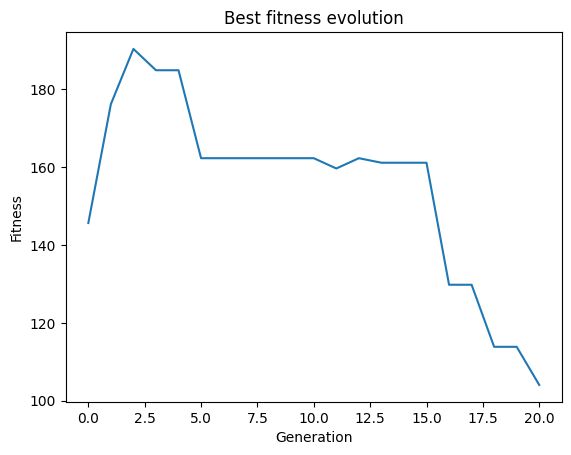

In [15]:
plt.plot(best_fitness_per_gen_QF)
plt.title("Best fitness evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

### Travel Salesman Problem (TSP)

El objetivo es minimizar la distancia total recorrida. De manera que se puede definir la función objetivo como:

$$
f(\pi) = d(\pi_n, \pi_1) + \sum_{i=1}^{n-1} d(\pi_i, \pi_{i+1}),
$$

donde $d(i, j)$ es la distancia entre la ciudad $i$ y la ciudad $j$. Así, el algoritmo acepta la mutación si $f(\pi_{nuevo}) < f(\pi _{actual})$.

In [16]:
n = 5 # Número de ciudades
popsize = 5 # Tamaño de la población

In [17]:
distance_matrix = np.zeros([n, n])
for i in range(n):
    for j in range(i):
        distance_matrix[i, j] = distance_matrix[j, i] = random.randint(1, 10)

In [18]:
def calculate_total_distance(tour, dist_matrix = distance_matrix):
    total_dist = 0
    for i in range(len(tour)-1):
        total_dist += dist_matrix[tour[i]][tour[i + 1]]
    total_dist += dist_matrix[tour[-1]][tour[0]]
    return total_dist
    
def mutation_TSP(tour, mutation_rate=0.1):
    new_tour = tour.copy()
    if random.random() <= mutation_rate:
        indx1, indx2 = random.sample(range(len(tour)), 2) # Seleciona dos indices aleatoriamente
        new_tour[indx1], new_tour[indx2] = new_tour[indx2], new_tour[indx1] # Se intercambia el valor de los items con los indicies selecionados anteriormente
    return new_tour

In [19]:
# Inicialización de la población inicial (tours inicial aleatorio)
initial_pop_TSP = [random.sample(range(n), n) for _ in range(popsize)]  # Generamos una poblacioón permutando las ciudades

print(f'Distancia entre caminos: {distance_matrix}')
# Mejor individuo inicial
best = min(initial_pop_TSP, key=calculate_total_distance)
print("Mejor inicial:", best, "->", calculate_total_distance(best))

Distancia entre caminos: [[0. 5. 3. 5. 6.]
 [5. 0. 8. 5. 6.]
 [3. 8. 0. 4. 6.]
 [5. 5. 4. 0. 2.]
 [6. 6. 6. 2. 0.]]
Mejor inicial: [4, 0, 2, 3, 1] -> 24.0


In [20]:
parents = initial_pop_TSP
num_generations = 20
size_offspring = 3
mutation_rate = 0.2

best_fitness_per_gen_TSP = []
best_fitness_per_gen_TSP.append(calculate_total_distance(best))
for _ in range(num_generations):
    # Selección
    selection = RWS(parents, calculate_total_distance, popsize, minimize=True)
    # Cruza y mutación
    offspring = []
    for i in range(0, size_offspring, 2):
        p1 = selection[i % len(selection)]
        p2 = selection[(i + 1) % len(selection)]
        crossover = one_point_crossover(p1, p2)
        for ind in crossover:
            offspring.append(mutation_TSP(ind, mutation_rate)) # mutación de los individuos
    offspring = offspring[:size_offspring]  # Limitar a tamaño de población
    # Reemplazo
    parents = elitism_replacement(parents, offspring, calculate_total_distance, popsize-1, minimize=True)
    best_fitness = min([calculate_total_distance(ind) for ind in parents])
    best_fitness_per_gen_TSP.append(best_fitness)

# Mejor individuo final
best = min(parents, key=calculate_total_distance)
print("Mejor final:", best, "->", calculate_total_distance(best))

Mejor final: [1, 1, 4, 3, 3] -> 13.0


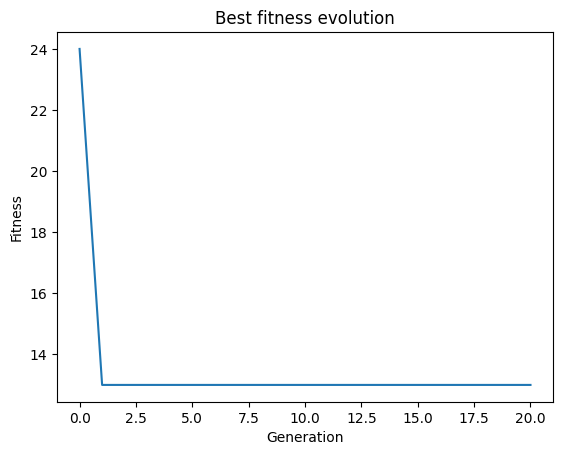

In [21]:
plt.plot(best_fitness_per_gen_TSP)
plt.title("Best fitness evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

### Knapsack problem (KP)

Función heurística:
El objetivo es maximizar el valor total de los artículos seleccionados, sujeto a la restricción de peso.

$$
h(x) = \left\{\begin{matrix}
 -1,\;\;\; \text{if} \;\;\; \sum (w_i \cdot x_i) > \text{Peso máximo}\\
  \sum (v_i \cdot x_i), \;\;\; \text{en caso contrario}
\end{matrix}\right.
$$

In [22]:
n_items = 5 # número de items para elegir
max_weight = 25 # peso máximo permitido
popsize = 5 # Tamaño de la población
# Define los pesos y valores de los objetos
value_list = np.array([random.randint(1, 50) for _ in range(n_items)])
weight_list = np.array([random.randint(1, 20) for _ in range(n_items)])

In [23]:
# Define la función heurística
def h(state, values = value_list, weights = weight_list, maxweight = max_weight):
    value = 0 
    if state @ weights > maxweight:
        value = -1 # Si el valor total de los objetos se pasa del máximo se retorna infinito
    else:
        value = state @ values # En caso contrario se retorna el valor total de los objetos
    return value

In [24]:
#Define la población de estados iniciales aletoriamente
initial_pop_KP = [np.array([random.randint(0, 1) for _ in range(n_items)]) for _ in range(popsize)]

best = max(initial_pop_KP, key=h)
print("Mejor inicial:", best, "->", h(best))

Mejor inicial: [0 1 0 1 0] -> 63


In [25]:
# Generar vecinos
def mutation_KP(state, mutation_rate):
    newstate = state.copy()
    if random.random() <= mutation_rate:
        idx_to_mutate = random.randint(0, n_items - 1)
        newstate[idx_to_mutate] = 1 - newstate[idx_to_mutate]  # Cambia el valor (si 0 -> 1 y si 1 -> 0)
    return newstate

In [26]:
parents = initial_pop_KP
num_generations = 20
size_offspring = 3
mutation_rate = 0.2

best_fitness_per_gen_KP = []
best_fitness_per_gen_KP.append(h(best))
for _ in range(num_generations):
    # Selección
    selection = SUS(parents, h, popsize, minimize=False)
    # Cruza y mutación
    offspring = []
    for i in range(0, size_offspring, 2):
        p1 = selection[i % len(selection)]
        p2 = selection[(i + 1) % len(selection)]
        crossover = uniform_crossover(p1, p2)
        for ind in crossover:
            offspring.append(mutation_KP(ind, mutation_rate)) # mutación de los individuos
    offspring = offspring[:size_offspring]  # Limitar a tamaño de población
    # Reemplazo
    parents = tournament_similar_replacement(parents, offspring, h, minimize=False)
    best_fitness = max([h(ind) for ind in parents])
    best_fitness_per_gen_KP.append(best_fitness)

# Mejor individuo final
best = max(parents, key=h)
print("Mejor final:", best, "->", h(best))

Mejor final: [0 1 1 1 0] -> 113


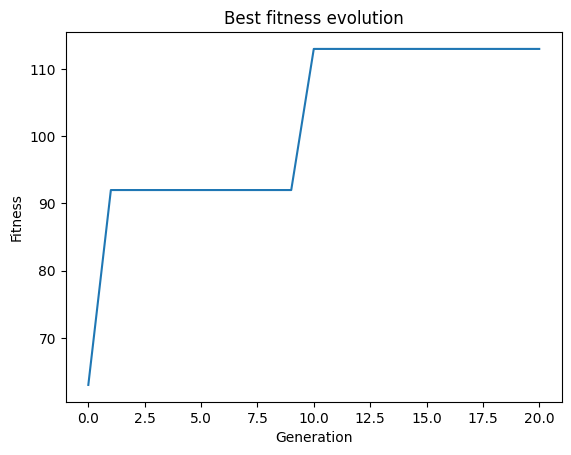

In [27]:
plt.plot(best_fitness_per_gen_KP)
plt.title("Best fitness evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()